## Домашняя работа №1 Part1
Вам предстоит:

Написать персептрон с двумя слоями. Реализовать форвард и бэквард пропогейшен



In [1]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

# Датасет
Загрузим Мнист. Почему именно он? Мы будем решать задачу бинарной классификации на паре цифр: 3 и 7. Плюсы в том, что примеров для этих чисел достаточно, чтобы обучить НС, у каждого примера не так много фичей (28Х28 - размерность картинок) и, в целом, эти классы хорошо отделяются. Я б с радостью показал вам пример с текстами, но если писать НС с нуля и пытаться обучаться на текстах, не факт, что у нас хоть что то обучится :(  
  

Торч - объект, который позволяет нормализовать картинки, можно думать о нем как о предобработке (регулярках) для текстов. В целом не стоит здесь долго думать

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Загружаем датасет. Возращается особенный торчовый класс, чуть ниже мы зададим его сами и научимся им полльзоваться, пока оставляем эз из.


In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Выбираем два класса. Если вы достаточно хорошо знакомы с пандас, то можно понять, что никакой магии здесь нет.

In [4]:
#фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3 или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
#тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
#необходимы препроцессинг лейблов, видимо не все значения имею тип integer, а нам нужен именно этот тип функция лонг позволяет нам 
#        это сделать (self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

Мы неоднократно говорили, что НС обычно тренируются бачами, в торче есть удобный класс, который позволяет обернуть наши датасеты в итерируемый объект. Если не знаете что такое итерируемый объект, погуглите :) можно думать об этом как о списке с составными элементами (элемент - батч - набор примеров) 

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [6]:
X, y = next(iter(train_loader)) #next(iter(x) - Возвращает следующий элемент итератора.
X

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [7]:
y

tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 0])

Никакой магии, просто многомерные матрицы. Можно даже проверить, что то, что мы получили, то есть первый батч имееет правильную размерность.В y - 1 это класс цифры "7", 0 - "3"

In [8]:
X.shape #128 - примеров, [1, 28, 28] - размерность картинки, 1 - значит что из трех каналов (Р, Г, Б) у нас всего один, а сама картинка 28 на 28

torch.Size([128, 1, 28, 28])

In [9]:
y.shape

torch.Size([128])

Проверим, правда ли это картинки

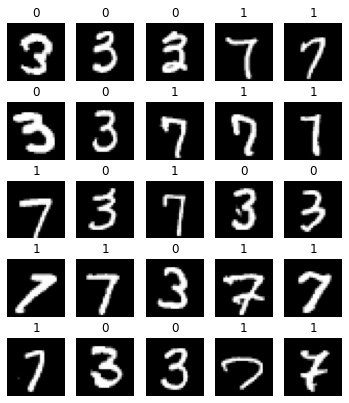

In [10]:
X, y = next(iter(train_loader))
X = X.numpy() # перевод тензора в массив нумпай, просто изменение типа данных 
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Нам столько размерностей не нужно, поэтому давайте выпрямим матрицу, тем боле мы знаем что значение каждого пикселя независимо друг друга.

In [11]:
X, y = next(iter(train_loader))
X = X.view(X.shape[0], -1)
X.shape

torch.Size([128, 784])

 Размерность
- количество примеров в батче
- количество фичей

In [12]:
y

tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 1])

Такой У нам не совсем подходит. Сейчас объясню почему. Размерность Х (128,784) матрично перемножим на скрытый слой (784,1) и получится (128,1). Нужно понимать, что размерность (128,) и (128,1) это немного разные вещи  

In [13]:
w = torch.rand(784, 1) #Рандомные необученые веса
pred = X.matmul(w)
pred.shape

torch.Size([128, 1])

In [14]:
pred

tensor([[ 15.5877],
        [-58.9601],
        [ 70.3295],
        [-28.5011],
        [-12.1558],
        [-12.1859],
        [-16.5324],
        [125.2350],
        [-32.1967],
        [  7.3316],
        [  6.6315],
        [-36.9290],
        [ 91.3586],
        [-35.1707],
        [-25.7579],
        [-20.8743],
        [  8.5294],
        [  0.4900],
        [-11.2021],
        [ 91.0710],
        [ 36.3644],
        [ 71.5135],
        [-42.9084],
        [-37.3651],
        [-11.0005],
        [-46.8382],
        [ 12.0348],
        [ -6.6427],
        [-53.8702],
        [ 45.2398],
        [121.2344],
        [ 59.5135],
        [-76.8369],
        [-66.6921],
        [ 27.7810],
        [ 63.7131],
        [  8.3443],
        [ 13.4002],
        [ -7.7669],
        [ 64.4239],
        [ 52.8181],
        [ -7.5215],
        [ 31.5096],
        [-26.0804],
        [ 54.7344],
        [  4.3595],
        [-66.1983],
        [-97.0519],
        [-47.0140],
        [  5.5084],


Теперь у нас есть предсказания и их размерность (128,1). Нужно будет счтить лосс с у, поэтому приведем его к такой же размерности с expand_dims - это функция есть в нумпае, также есть и в торче

In [15]:
y = np.expand_dims(y, 1)

In [16]:
y

array([[0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
    

Итерация по эпохам

In [17]:
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными, например, учить, но пока этого делать не будет
        
        time.sleep(0.05)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Однослойный персептрон

In [18]:
learning_rate = 0.01 # тот самый лернинг рейт, который определяет какую часть от градиента мы будем брать
epochs = 5  #сколько раз мы пройдем по всему тренировачному набору наших данных

batch_size = 128  #это число примеров в баче понадобится нам при обучении чтобы усреднять лосс (ошибку обучения)
n_feat = 784

w1 = np.random.rand(n_feat,1)*0.01 #0.01 - нормируем таким образом наши веса, чтобы избежать деления на ноль при бэкпропе, 
                                    #эмпирически выбрано, так как сами фичи у нас имеют значения близкие к 0
b1 = np.zeros(1) #размерность должна совпадать с количеством параметров, которые у нас останутся после матричного перемножения

losses = [] #на каждой итерации (и для всех эпох) будем сохранять сюда наш Лосс, чтобы видеть обучается ли НС

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:

        x = x.view(x.shape[0], -1).numpy() #приводим к размерности (128,784)
        y = np.expand_dims(y.numpy(), 1) #приводим к размерности (128,1)

        h1 = x.dot(w1) + b1 #переход в одномерное пространство
        p = 1/(1+np.exp(-h1)) #преобразование в "вероятности"
        
        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
        #расчет энтропии с усреднением по размеру бача
          
        losses.append(bce) 
        #ниже производная bce и sigmoid, если вы распишите две этих производные, перемножите и сократите, то полчится следующая строчка
        dp = (p - y) / batch_size 
        dw1 = np.dot(x.T, dp) # производная по линейному преобразванию, относительно W - весов 
        db1 = np.sum(dp) # производная по лин преобразованиюб относительно В - баяса, 
        #здесь по идее должно быть перемножение на единичный вектор (128,1), но это тоже самое что и сумма значениеб типа лайф хак
        
        w1 -= learning_rate * dw1 # Обновим веса и баясы 
        b1 -= learning_rate * db1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


А теперь построим график функции потерь

Text(0, 0.5, 'Loss function')

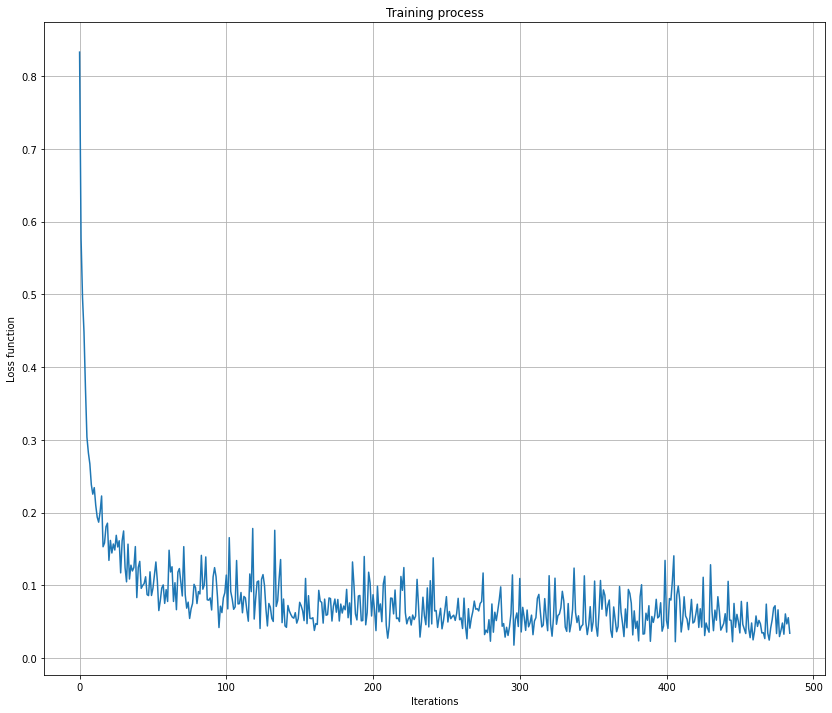

In [19]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

## Математика 


![alt text](https://sun9-39.userapi.com/c850608/v850608777/47a4/fgZlI898IUU.jpg)
![alt text](https://sun9-41.userapi.com/c858216/v858216777/cc4f5/v3CPa-tnm80.jpg)
![alt text](https://sun9-67.userapi.com/c857632/v857632471/f6e95/H0dsmWsUInc.jpg)
![alt text](https://sun9-71.userapi.com/c858120/v858120274/10d0ef/hdKO-3Syk3g.jpg)



А теперь ваша очередь, нужно написать двуслоный персептрон, согласно коду и выкладкам выше

In [93]:
### КОД СЮДА ###

learning_rate = 0.01 # тот самый лернинг рейт, который определяет какую часть от градиента мы будем брать
epochs = 5  #сколько раз мы пройдем по всему тренировачному набору наших данных

batch_size = 128  #это число примеров в баче понадобится нам при обучении чтобы усреднять лосс (ошибку обучения)
n_feat = 784

inner_feat = 100 # число фичей, которое хотим оставить на второй слой

w1 = np.random.rand(n_feat, inner_feat) * 0.01 #0.01 - нормируем таким образом наши веса, чтобы избежать деления на ноль при бэкпропе, 
                                    #эмпирически выбрано, так как сами фичи у нас имеют значения близкие к 0
b1 = np.zeros(inner_feat) #размерность должна совпадать с количеством параметров, которые у нас останутся после матричного перемножения

w2 = np.random.rand(inner_feat, 1) * 0.01
b2 = np.zeros(1)

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1).numpy() #приводим к размерности (128,784)
        y = np.expand_dims(y.numpy(), 1) #приводим к размерности (128,1)
        
        ### КОД СЮДА ###
        
        # forward
        z1 = x.dot(w1) + b1 #переход в одномерное пространство
        a1 = 1/(1 + np.exp(-z1)) #применение сигмоиды
        z2 = a1.dot(w2) + b2
        a2 = 1/(1 + np.exp(-z2))
        p = a2

        # рассчет bce
        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
        
        # backward
        losses.append(bce) 
        
        dz2 = (p - y) / batch_size 
        dw2 = np.dot(a1.T, dz2)
        db2 = np.sum(dz2)
        da1z1 = 1 - ((np.exp(z1) - np.exp(-z1)) / (np.exp(z1) + np.exp(-z1)))
        dLa1 = np.multiply(w2.T, da1z1)
        dLz1 = np.multiply(dLa1, dz2)
        dw1 = np.dot(x.T, dLz1)
        db1 = np.sum(dLz1)

        # gradient descent
        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2
        w1 -= learning_rate * dw1
        b1 -= learning_rate * db1

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - Применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred or A2- сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_BCE/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- dz2/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- dz2/db2 - градиент линейного преобразования по b2 - (1,)
- da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

и график нарисуйте

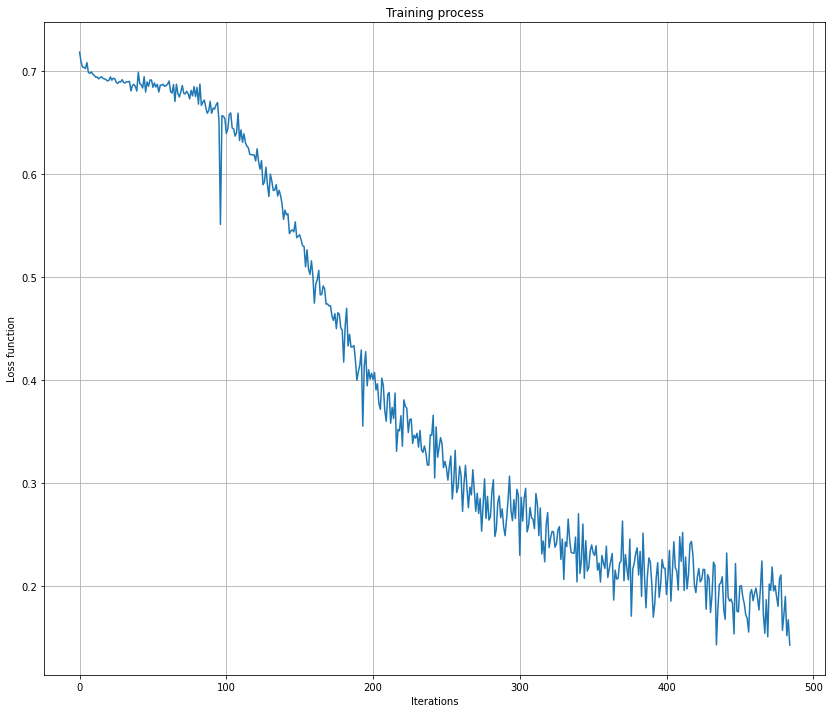

In [94]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Тестирование

А как это тестировать? Да, очень просто нужно просто выполнять форвард без бэкворда, то есть последовательно применять преобразования с обученными весами

In [95]:
losses_test = []
predicted = []
true_lbls = []

for x, y in test_loader:

  x = x.view(x.shape[0], -1).numpy()
  y = np.expand_dims(y.numpy(), 1)

  h1 = x.dot(w1) + b1 #переход в одномерное пространство
  p = 1/(1+np.exp(-h1)) #преобразование в "вероятности"
  
  bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
  #расчет энтропии с усреднением по размеру бача
    
  losses_test.append(bce)
  predicted.extend(p)
  true_lbls.extend(y) 

Проверим, что для каждого семплау нас есть предсказание

In [96]:
print(len(predicted), len(true_lbls))

2038 2038


Теперь применим стандартную Ф меру и оценим нашу модель

In [97]:
from sklearn.metrics import f1_score
pred = np.array([round(i[0]) for i in predicted]) 
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы 
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.77


Сделайте тоже самое для своей модели...

In [99]:
losses_test = []
predicted = []
true_lbls = []


for x, y in train_loader:
      
  x = x.view(x.shape[0], -1).numpy() #приводим к размерности (128,784)
  y = np.expand_dims(y.numpy(), 1) #приводим к размерности (128,1)
  
  z1 = x.dot(w1) + b1 #переход в одномерное пространство
  a1 = 1/(1 + np.exp(-z1)) #применение сигмоиды
  z2 = a1.dot(w2) + b2
  a2 = 1/(1 + np.exp(-z2))
  p = a2

  # рассчет bce
  bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
    
  losses_test.append(bce)
  predicted.extend(p)
  true_lbls.extend(y)   

In [100]:
print(len(predicted), len(true_lbls))

12396 12396


In [101]:
pred = np.array([round(i[0]) for i in predicted]) 
# У нас были вероятности а нужны классы поэтому просто округлим каждое значени и получим лейблы 
t_lbls = np.array(true_lbls).squeeze() #снимем лишнюю размерность
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.96


# Немного торча

In [102]:
import torch

### Мы можем определить нашу модель как последовательность уже существующих слоев, как в керасе

In [103]:
model = torch.nn.Sequential()

model.add_module(name='linear_1', module=torch.nn.Linear(in_features=784, out_features=256))
model.add_module(name='relu', module=torch.nn.ReLU())
model.add_module(name='linear_2', module=torch.nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=torch.nn.Sigmoid())

model

Sequential(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Либо так

In [104]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=1),
    torch.nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
  (3): Sigmoid()
)

## А вот для чего нужно было писать в домашке классы
## Для определения своих моделей/слоев/чего вам захочется нам нужно сделать такую структуру

In [105]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):
    
    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    # 
    # передаем ссылку на самого себя первым параметром
    # 
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    # 
    def __init__(self, in_features, inner_features, out_features):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.sigmoid = torch.nn.Sigmoid()
        
    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):
        
        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)
        
        return x
    
    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [106]:
# определяем нашу модель
model = MLP(in_features=784, inner_features=256, out_features=1)

In [107]:
model

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [108]:
# можем посмотреть веса
model.linear_1.weight.shape

torch.Size([256, 784])

In [109]:
# еще нам нужно задать функцию потерь 
criterion = torch.nn.BCELoss()

In [110]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [111]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

[Parameter containing:
 tensor([[-0.0231,  0.0208,  0.0061,  ...,  0.0095, -0.0172,  0.0290],
         [-0.0187,  0.0155,  0.0257,  ..., -0.0143, -0.0204, -0.0239],
         [-0.0308,  0.0333,  0.0129,  ...,  0.0154, -0.0355, -0.0005],
         ...,
         [ 0.0241, -0.0095,  0.0311,  ...,  0.0232, -0.0066,  0.0041],
         [ 0.0357,  0.0305,  0.0162,  ...,  0.0205,  0.0220,  0.0242],
         [-0.0085,  0.0312, -0.0081,  ...,  0.0314, -0.0091,  0.0215]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0054,  0.0193, -0.0244,  0.0182, -0.0144, -0.0206,  0.0331, -0.0133,
         -0.0201,  0.0222, -0.0342,  0.0313, -0.0276,  0.0195,  0.0013, -0.0099,
         -0.0204,  0.0077, -0.0272, -0.0300, -0.0100, -0.0166,  0.0177,  0.0074,
         -0.0107, -0.0317,  0.0272,  0.0113, -0.0117,  0.0081, -0.0301,  0.0216,
         -0.0053, -0.0305,  0.0068,  0.0353,  0.0039, -0.0175, -0.0328, -0.0078,
         -0.0299,  0.0037, -0.0339,  0.0067,  0.0112,  0.0074,  0.0293, -0.0193,

# Обучим нашу модель

In [112]:
# давайте сохранять значения нашей функции потерь каждую итерацию обучения
losses = []

# эта штука все еще отдает нам батчи данных
# мы поговорим про нее позже
for x, y in train_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # обновим наши градиенты
    # будем делать это каждую итерацию обучения
    # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
    # 
    # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
    # функция сохранения градиентов нужна для аккамуляции градиентов
    # например, когда нам не хватает памяти на большой батч
    # мы можем несколько раз прогнать forward на разных батчах
    # наши градиенты будут сохраняться
    # и только потом обновить через несколько итераций forward обновить наши веса
    # таким образом у нас получается больше батч
    # 
    optimizer.zero_grad()
    
    # 
    # предсказание нашей модели
    # здесь торч сам сохраняет необходимую информацию
    # чтобы понять эту логику у нас как раз и была часть домашки про собственные классы
    # 
    # торч строит динамический граф вычислений
    # то есть строит граф по тем операциям, которые вы определили в методе forward
    # 
    # то есть торч понимает, что вы сначала применили линейное преобразование
    # знает, где лежат веса для этого линейного преобразования
    # знает, что вы затем применили релу
    # затем опять линейное преобразование
    # затем сигмоиду
    # и вот таким образом торч выстроил граф
    # который нужен будет для backpropogation
    # 
    pred = model(x)
    
    # 
    # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
    # 
    loss = criterion(pred, y.float())
    
    # 
    # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
    # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
    # передаем градиенты на следующие узлы
    # для весов сохраняет
    # 
    # то есть это почти то же самое, что мы делали в домашке с классами
    # 
    loss.backward()
    
    # 
    # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
    # 
    optimizer.step()
    
    # 
    # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
    # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
    # чтобы граф не строился дальше на каждой итерации обучения
    # так мы рано или поздно переполним память
    # поэтому вызываем этот метод
    # работает для скаляров
    # 
    # для тензоров работает метод .tolist()
    # 
    current_loss_value = loss.item()
    losses.append(loss.item())

In [113]:
# Одна эпоха прошла

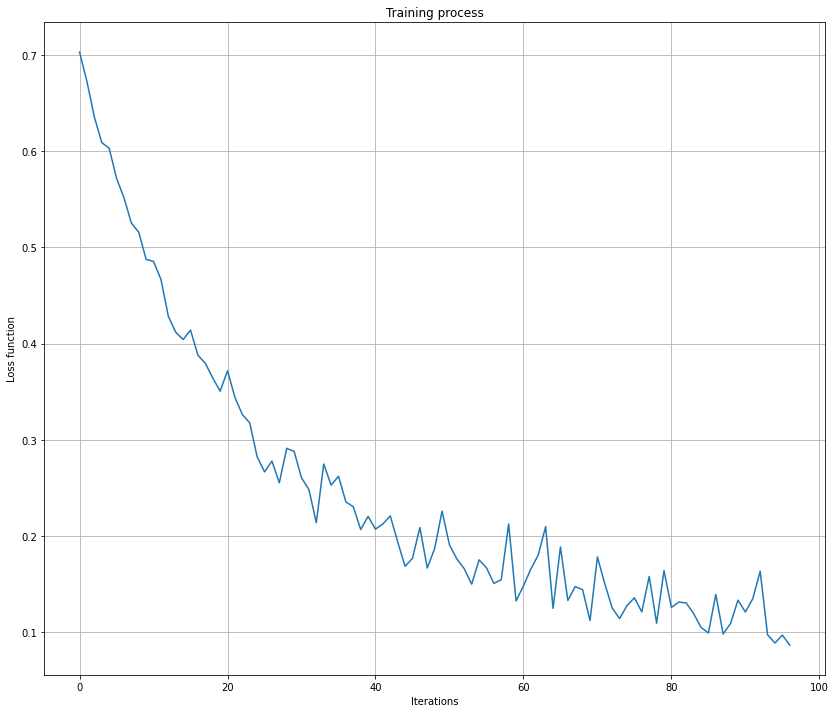

In [114]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Теперь мы можем что-то предсказать

In [115]:
for x, y in test_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # чтобы не ходить по всему тестовому датасету, прекратим ходить после первой итерации
    break

In [116]:
x.shape

torch.Size([128, 784])

In [117]:
y.shape

torch.Size([128, 1])

In [118]:
# переходим в режим предсказания
# 
# позже в курсе мы разберем зачем конкретно это нужно
# 
# для искушенного нетерпеливого читателя: дропаут больше не дропаутит, батч норм больше не нормирует каждый батч
# а использует накопленную статистику при обучении и тд
# 
model.eval()

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [119]:
# этот контект позволяет не сохранять необходимую информацию для рассчета градиентов
with torch.no_grad():

    pred = model(x)

In [120]:
pred.shape

torch.Size([128, 1])

In [121]:
# избавимся от единичной размерности
pred = pred.squeeze()
y = y.squeeze()

In [122]:
pred.shape

torch.Size([128])

In [123]:
# таким образом из торчовых тензоров мы можем сделать нумпаевские массивы
pred = pred.numpy()
y = y.numpy()

In [124]:
y

array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)

In [125]:
type(y)

numpy.ndarray

In [126]:
# бинаризируем наши предсказания
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [127]:
# посчитаем метрику на батче
accuracy_score(y, pred)

0.9609375

In [128]:
# заново определим нашу модель и выучимся несколько эпох
# будут уже новые параметры
model = MLP(in_features=784, inner_features=256, out_features=1)

criterion = torch.nn.BCELoss()
# мы позже поговорим про этот оптимизационный алгоритм
optimizer = torch.optim.Adam(params=model.parameters())

# Типичный цикл обучения с кучей сохранений лоссов

In [129]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    # как раз early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    # пожалуй, самый популярный метод валидации для нейронных сетей
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break    

Epoch 1: 100%|██████████| 12396/12396 [00:03<00:00, 3636.05it/s, train_loss=0.0709]


Losses: train - 0.071, test = 0.048
Test: accuracy - 0.985


Epoch 2: 100%|██████████| 12396/12396 [00:02<00:00, 4557.23it/s, train_loss=0.0269]


Losses: train - 0.027, test = 0.030
Test: accuracy - 0.989


Epoch 3: 100%|██████████| 12396/12396 [00:02<00:00, 4660.55it/s, train_loss=0.0166]


Losses: train - 0.017, test = 0.025
Test: accuracy - 0.992


Epoch 4: 100%|██████████| 12396/12396 [00:02<00:00, 4672.49it/s, train_loss=0.0117]


Losses: train - 0.012, test = 0.024
Test: accuracy - 0.993


Epoch 5: 100%|██████████| 12396/12396 [00:02<00:00, 4593.41it/s, train_loss=0.00782]


Losses: train - 0.008, test = 0.019
Test: accuracy - 0.994


Epoch 6: 100%|██████████| 12396/12396 [00:02<00:00, 4709.30it/s, train_loss=0.0044]


Losses: train - 0.004, test = 0.024
Test: accuracy - 0.993
Early stopping


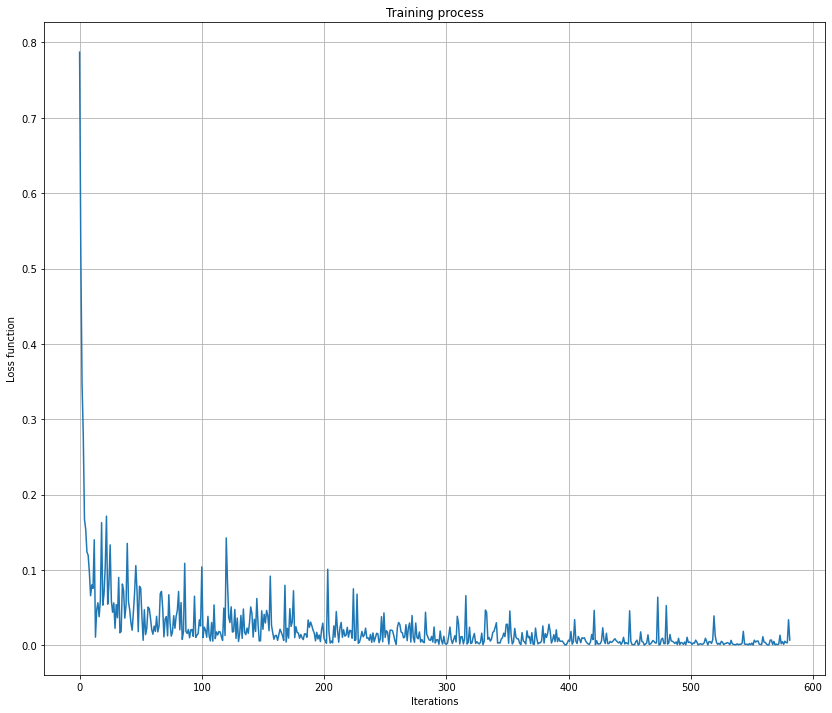

In [130]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');